In [1]:
import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap_hbb.json') as f:
  pmap = json.load(f)

In [3]:
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.2

year='2017'

In [4]:
indir = "../outfiles/notrigger/chunksize100000_noSF/"
infiles = subprocess.getoutput("ls "+indir+year+"*.coffea").split()
outsum = processor.dict_accumulator()

# Check if pickle exists, remove it if it does                                                                             
picklename = str(year)+'/templates.pkl'
if os.path.isfile(picklename):
    os.remove(picklename)
    
started = 0
for filename in infiles:

    print("Loading "+filename)

    if os.path.isfile(filename):
        out = util.load(filename)

        if started == 0:
            outsum['templates'] = out['templates']
            outsum['sumw'] = out['sumw']
            started += 1
        else:
            outsum['templates'].add(out['templates'])
            outsum['sumw'].add(out['sumw'])
    
        del out

Loading ../outfiles/notrigger/chunksize100000_noSF/2017_dask_data.coffea
Loading ../outfiles/notrigger/chunksize100000_noSF/2017_dask_higgs.coffea
Loading ../outfiles/notrigger/chunksize100000_noSF/2017_dask_qcd.coffea
Loading ../outfiles/notrigger/chunksize100000_noSF/2017_dask_top.coffea
Loading ../outfiles/notrigger/chunksize100000_noSF/2017_dask_wandvv.coffea
Loading ../outfiles/notrigger/chunksize100000_noSF/2017_dask_z.coffea


In [5]:
scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
outsum['templates'].scale(scale_lumi, 'dataset')

templates = outsum['templates'].group('dataset', hist.Cat('process', 'Process'), pmap)

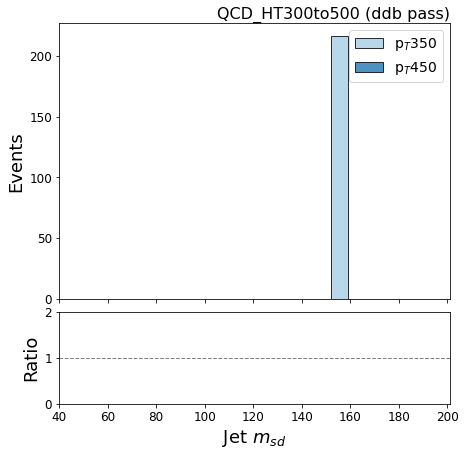

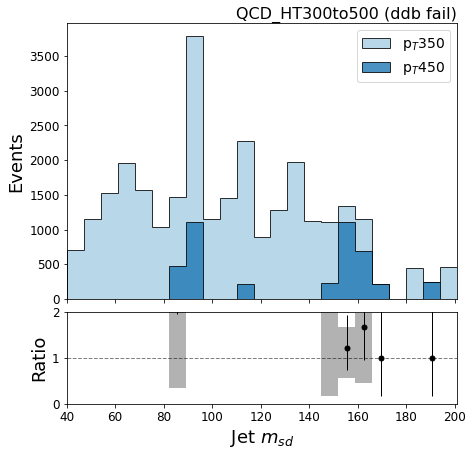

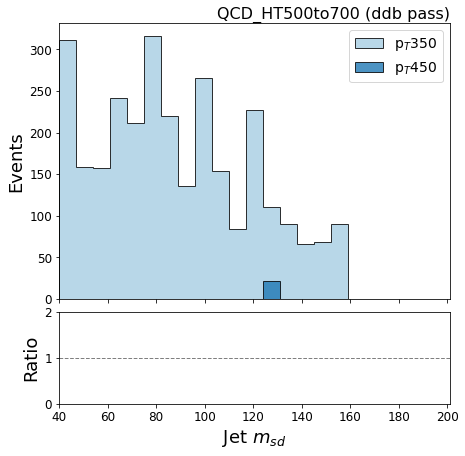

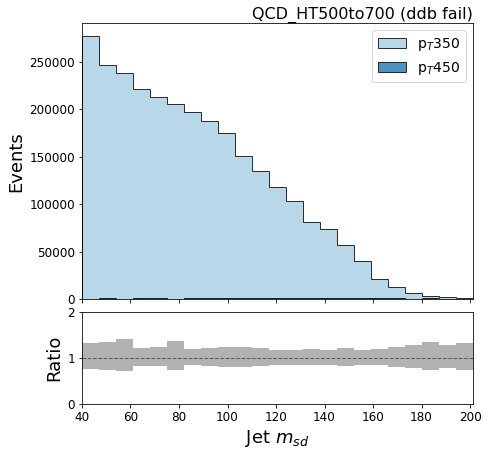

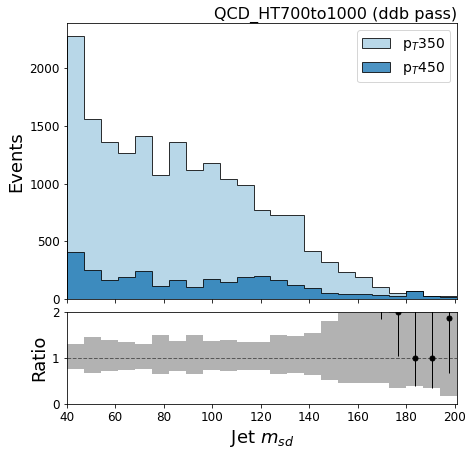

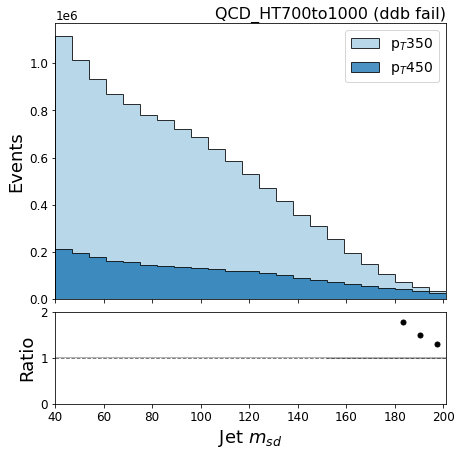

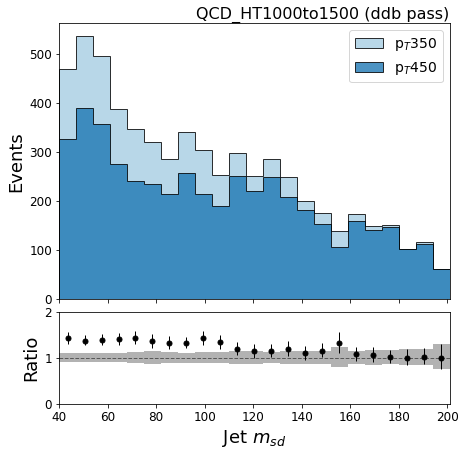

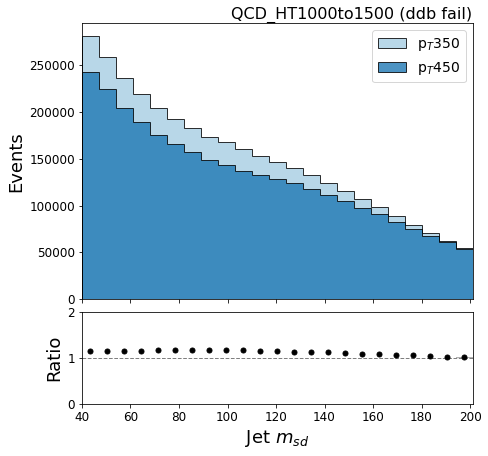

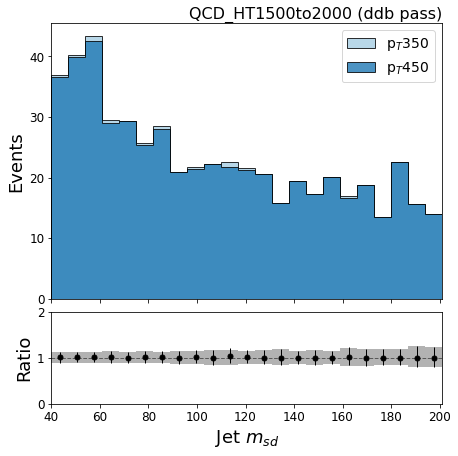

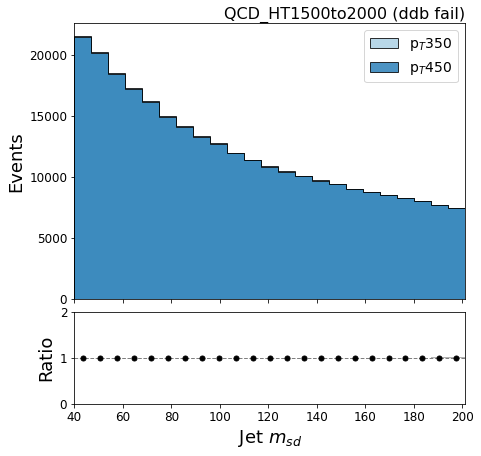

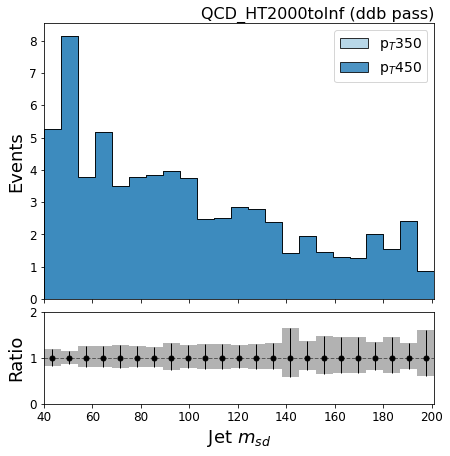

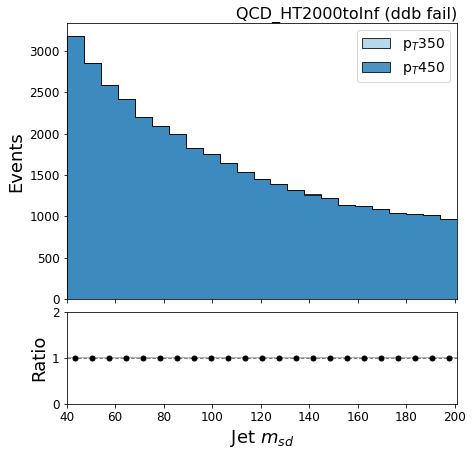

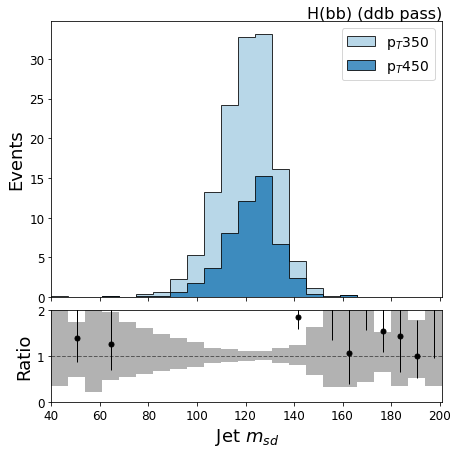

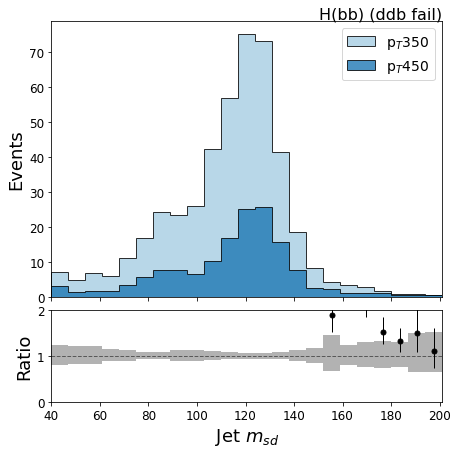

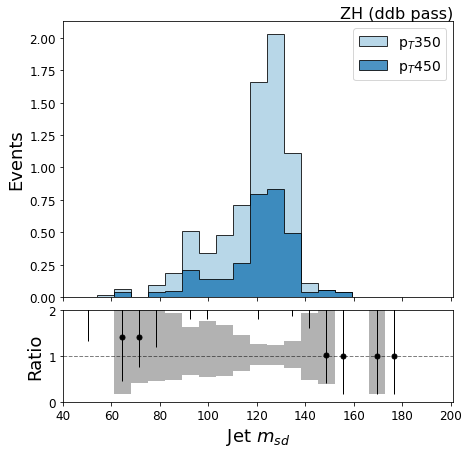

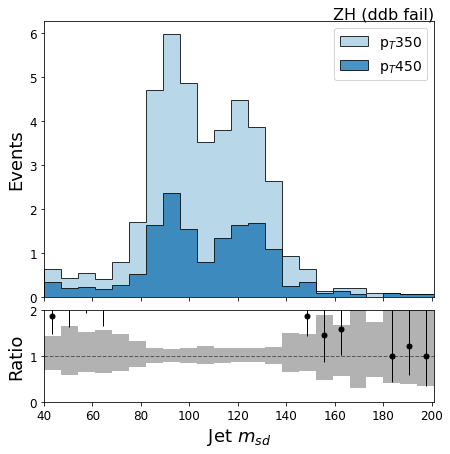

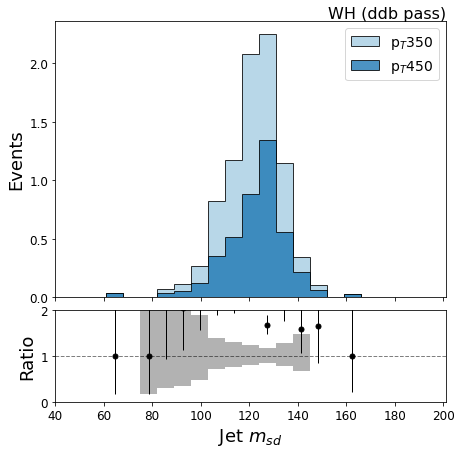

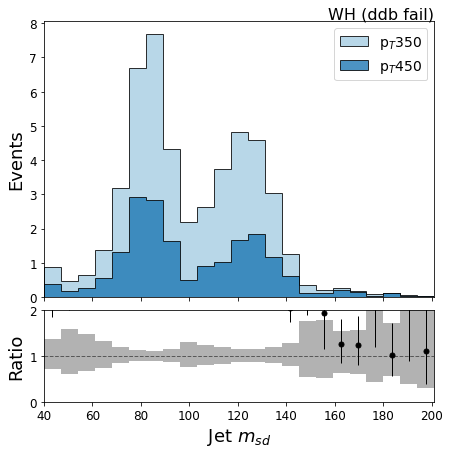

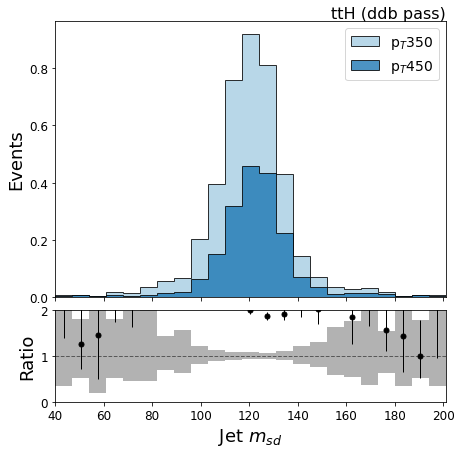

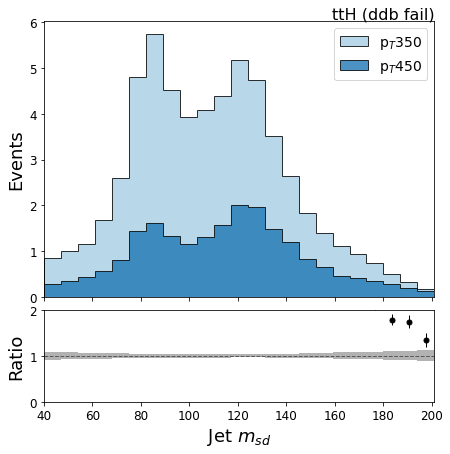

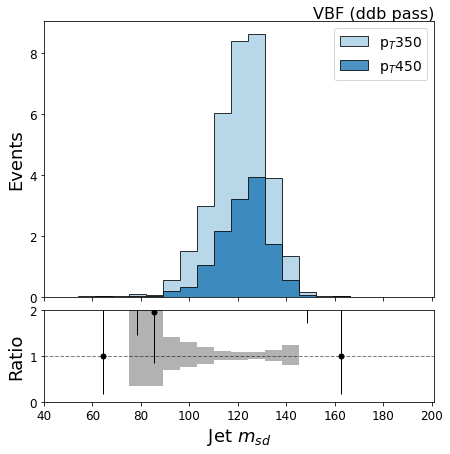

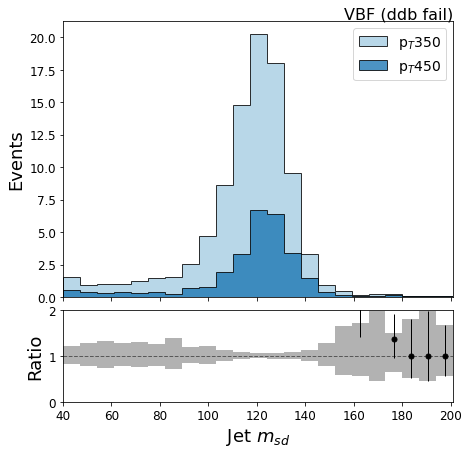

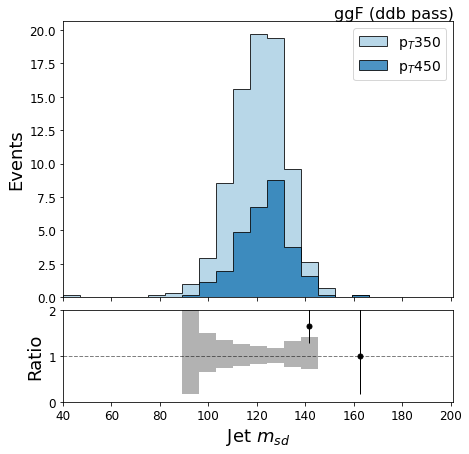

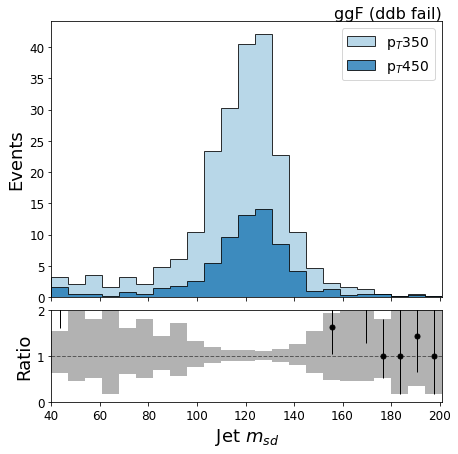

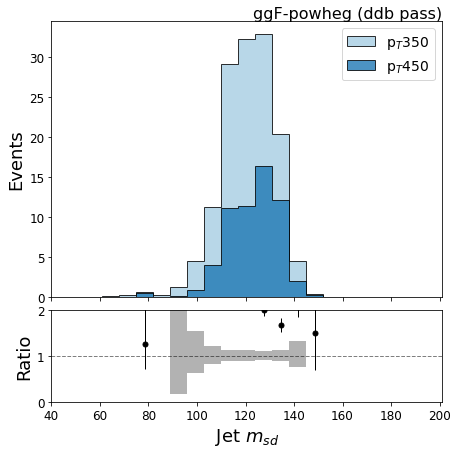

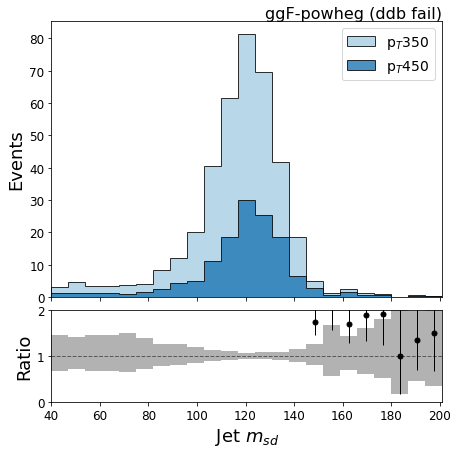

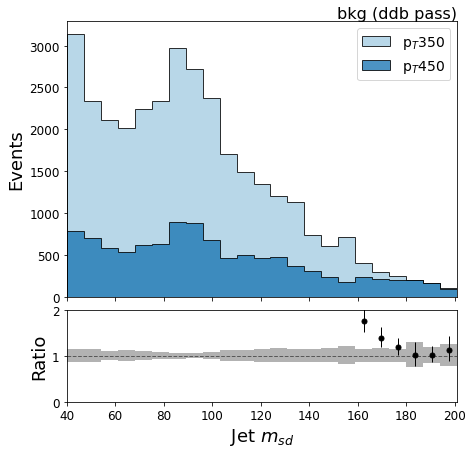

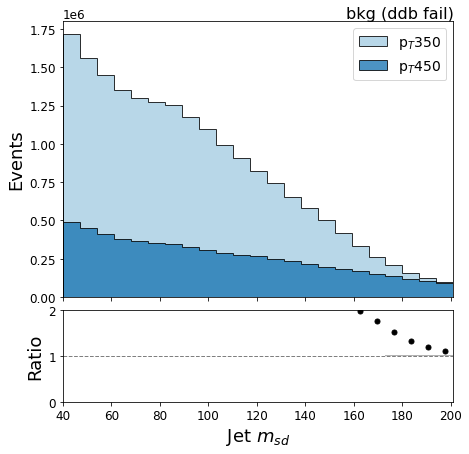

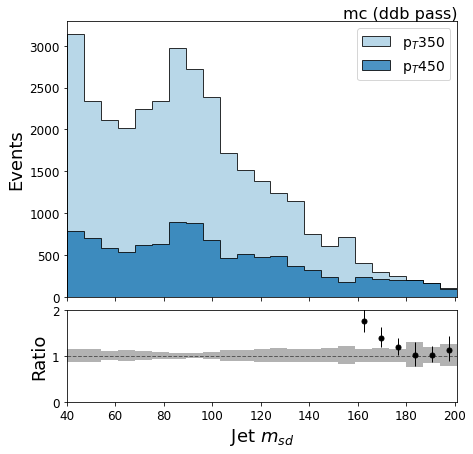

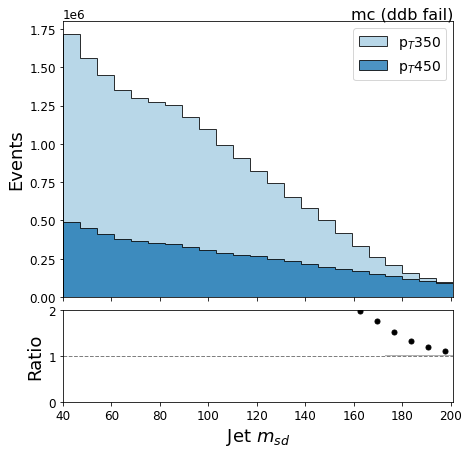

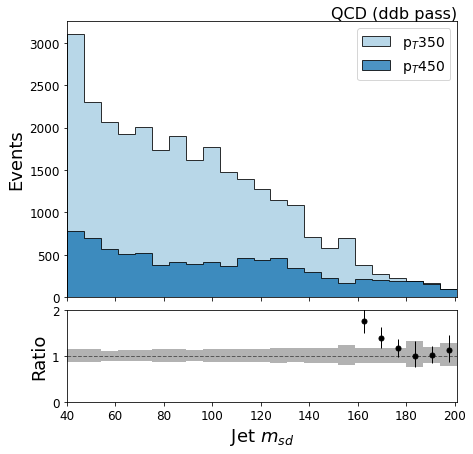

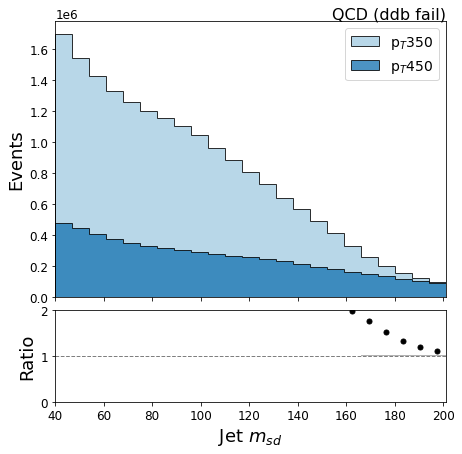

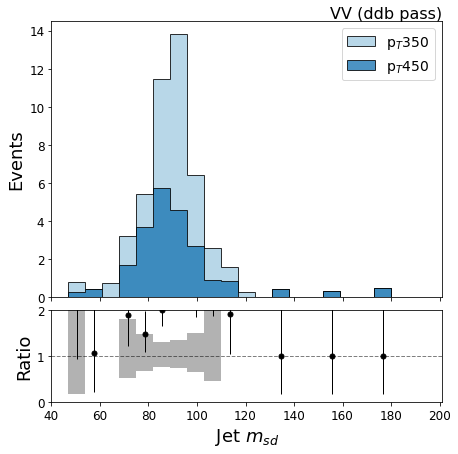

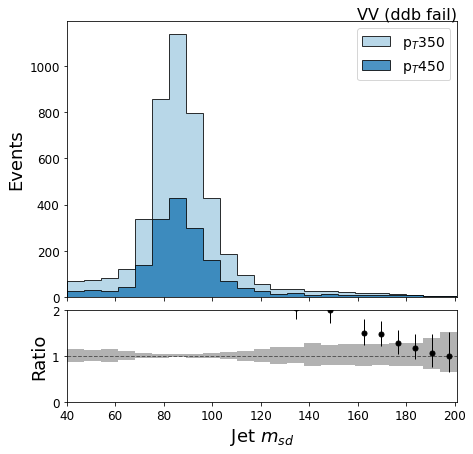

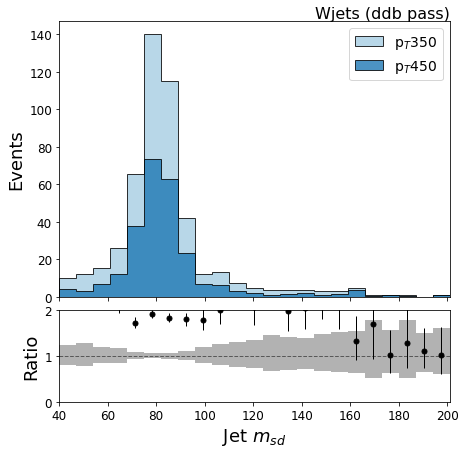

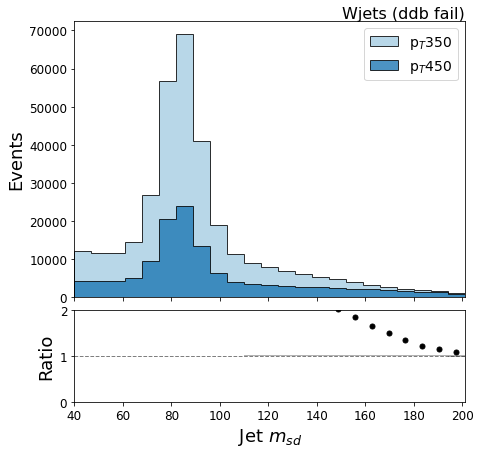

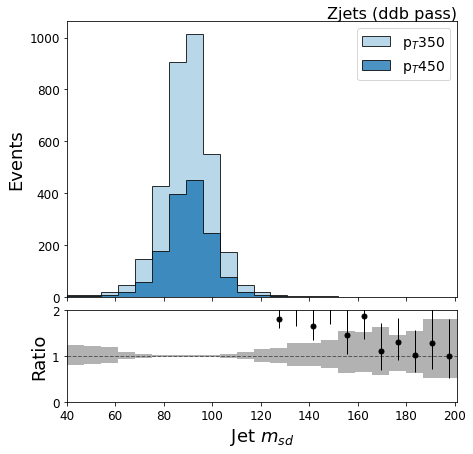

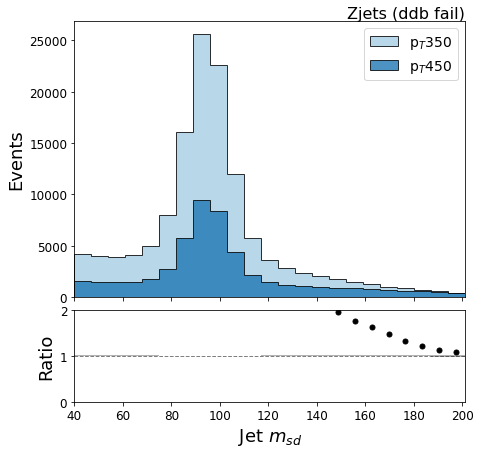

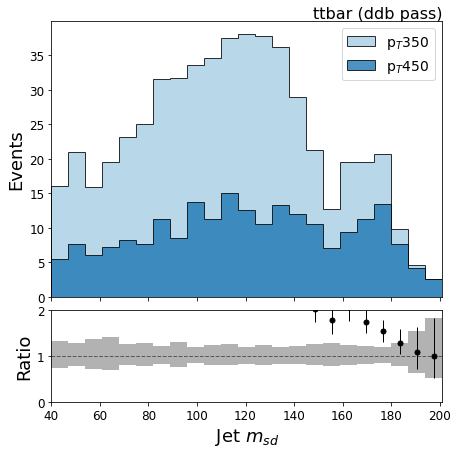

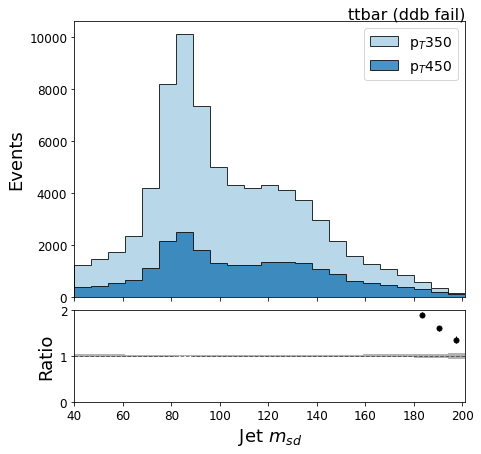

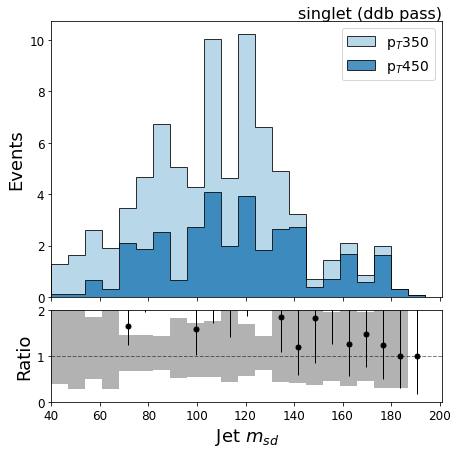

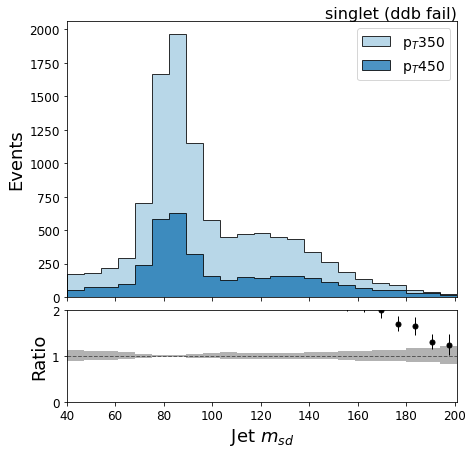

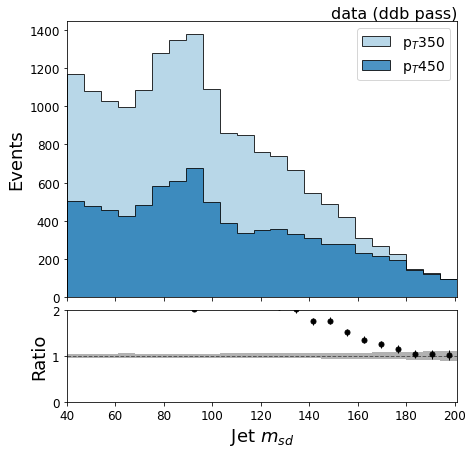

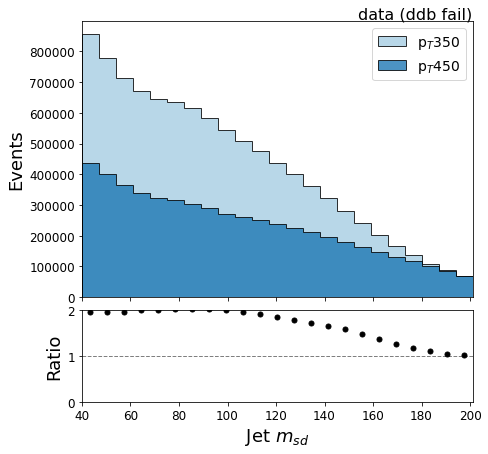

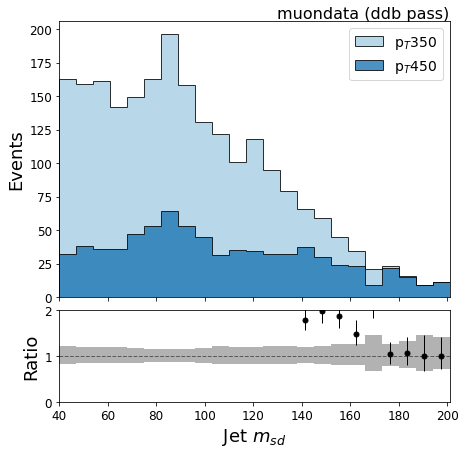

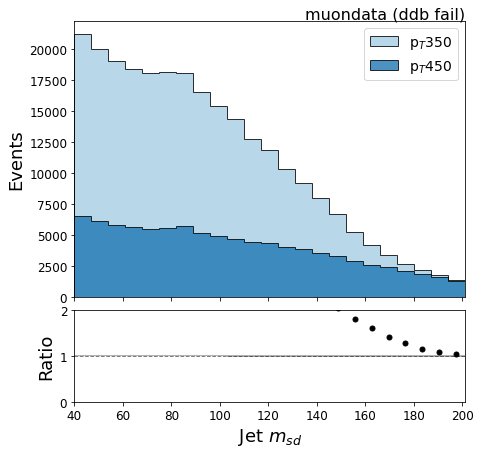

In [6]:
processes = [t[0] for t in templates.values().keys() if t[1] == 'signal']
#processes = ['H(bb)']
ddb_regions = ['pass', 'fail']

for process in processes:
    for ddb_region in ddb_regions:
        
        if ddb_region == 'pass':
            ddb_l = 0.64
            ddb_r = 1
        elif ddb_region == 'fail':
            ddb_l = 0
            ddb_r = 0.64

        h_pt350 = templates[process].integrate('region','signal').sum('genflavor').integrate('pt1',int_range=slice(350,1200)).integrate('ddb1',int_range=slice(ddb_l,ddb_r))
        h_pt450 = templates[process].integrate('region','signal').sum('genflavor').integrate('pt1',int_range=slice(450,1200)).integrate('ddb1',int_range=slice(ddb_l,ddb_r))

        #print(h_pt350.values())
        
        scale_pt350 = { process : -1 }
        h_pt350_pos = h_pt350.copy()
        h_pt350_neg = h_pt350.scale(scale_pt350, 'process')
        
        #print(scale_pt350)
        #print(h_pt350.values())
        

        # make a nice ratio plot, adjusting some font sizes
        plt.rcParams.update({
            'font.size': 14,
            'axes.titlesize': 18,
            'axes.labelsize': 18,
            'xtick.labelsize': 12,
            'ytick.labelsize': 12
        })
        fig, (ax, rax) = plt.subplots(
            nrows=2,
            ncols=1,
            figsize=(7,7),
            gridspec_kw={"height_ratios": (3, 1)},
            sharex=True
        )
        fig.subplots_adjust(hspace=.07)

        # Here is an example of setting up a color cycler to color the various fill patches
        # We get the colors from this useful utility: http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6
        from cycler import cycler
        colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
        ax.set_prop_cycle(cycler(color=colors))

        fill_opts = {
            'edgecolor': (0,0,0,0.3),
            'alpha': 0.8
        }
        error_opts = {
            'label': 'Stat. Unc.',
            'hatch': '///',
            'facecolor': 'none',
            'edgecolor': (0,0,0,.5),
            'linewidth': 0
        }
        data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'color': 'k',
            'elinewidth': 1,
        }

        # plot the MC first
        hist.plot1d(
            h_pt350_pos,
            overlay="process",
            ax=ax,
            clear=False,
            #stack=True,
            line_opts=None,
            fill_opts=fill_opts,
            error_opts=error_opts
        )

        hist.plot1d(
            h_pt450,
            overlay="process",
            ax=ax,
            clear=False,
            #stack=True,
            line_opts=None,
            fill_opts=fill_opts,
            error_opts=error_opts
        )

        ax.autoscale(axis='x', tight=True)
        ax.set_ylim(0, None)
        ax.set_xlabel(None)
        leg = ax.legend(labels=[r"p$_{T}$350", r"p$_{T}$450"])

        # now we build the ratio plot
        t = hist.plotratio(
            num=h_pt350_pos.sum("process"),
            denom=h_pt450.sum("process"),
            ax=rax,
            error_opts=data_err_opts,
            denom_fill_opts={},
            guide_opts={},
            unc='num'
        )
        rax.set_ylabel('Ratio')
        rax.set_ylim(0,2)

        lumi = plt.text(1., 1., process + ' (ddb ' + ddb_region + ')',
                        fontsize=16,
                        horizontalalignment='right',
                        verticalalignment='bottom',
                        transform=ax.transAxes
                       )
        fig.savefig('../plots/one_process_pt350_vs_pt450/' + process + '_' + ddb_region + '.png')